In [2]:
import torch
import torch.nn as nn
from transformers import CLIPVisionModelWithProjection, ViTForImageClassification, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, LlamaForCausalLM

import sys, os, json, math
from tqdm import tqdm
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/home/jgryu/miniconda3/envs/nic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def latest_version_path(cache_dir, model_name, branch = 'main'):
    model_name_dir =  "models--" + model_name.replace('/', '--')
    path = os.path.join(cache_dir, model_name_dir)
    if not os.path.isdir(os.path.join(path, 'snapshots')):
        return None
    branch_file =  os.path.join(path, 'refs', branch)
    with open(branch_file, 'r', encoding='utf-8') as file:
        revision = file.read()
    return os.path.join(path, 'snapshots', revision)

cache_directory = "../Wparam_dataset_v0/model_zoo/huggingface" 
ckpt_path = latest_version_path(cache_directory, 'meta-llama/Meta-Llama-3-8B')
net = LlamaForCausalLM.from_pretrained(ckpt_path, local_files_only=True)


ckpt_path = '/home/jgryu/Weight_compression/model_cache/models--meta-llama--Meta-Llama-3-8B/snapshots/8cde5ca8380496c9a6cc7ef3a8b46a0372a1d920'
# net = AutoModelForCausalLM.from_pretrained(ckpt_path, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(ckpt_path, local_files_only=True)
state_dict = net.state_dict()

Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


In [4]:
def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

In [5]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# # 저장할 폴더 생성
# output_folder = "./weight_plots/3d"
# os.makedirs(output_folder, exist_ok=True)

# # 플롯 생성 및 저장
# layers = net.model.layers

# for i in tqdm(range(len(layers))):
#     if i not in [0, 1, 10, 20, 31, 30]: 
#         continue

#     named_linears = get_named_linears(layers[i])
#     for n, m in named_linears.items():
#         print(i, n, m.weight.data.shape)

#         # 데이터 준비
#         z = torch.abs(m.weight.data).cpu().numpy()  # GPU 텐서를 CPU로 변환
#         x = np.arange(z.shape[1])  # 열 인덱스
#         y = np.arange(z.shape[0])  # 행 인덱스
#         x, y = np.meshgrid(x, y)

#         # 3D 플롯 생성
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')

#         # 3D surface plot
#         surf = ax.plot_surface(x, y, z, cmap='viridis')

#         # 축 레이블 설정
#         ax.set_xlabel('Columns (X axis)')
#         ax.set_ylabel('Rows (Y axis)')
#         ax.set_zlabel('Values (Z axis)')

#         # 색깔 막대 추가
#         fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

#         # 파일 이름 설정 및 저장
#         filename = f"layer_{i}_{n}.png"
#         save_path = os.path.join(output_folder, filename)
#         plt.title(filename)        
#         plt.savefig(save_path, dpi=300)
#         plt.close(fig)  # 메모리 누수를 방지하기 위해 플롯 닫기

# print(f"Plots saved to '{output_folder}' folder.")

In [6]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# # 저장할 폴더 생성
# output_folder = "./weight_plots/heatmap"
# os.makedirs(output_folder, exist_ok=True)

# # 플롯 생성 및 저장
# layers = net.model.layers

# for i in tqdm(range(len(layers))):
#     if i not in [0, 1, 10, 20, 31, 30]: 
#         continue

#     named_linears = get_named_linears(layers[i])
#     for n, m in named_linears.items():
#         print(i, n, m.weight.data.shape)

#         # 데이터 준비
#         z = torch.abs(m.weight.data).cpu().numpy()  # GPU 텐서를 CPU로 변환

#         # 2D heatmap 플롯 생성
#         fig, ax = plt.subplots(figsize=(8, 6))
#         heatmap = ax.imshow(z, cmap='viridis', aspect='auto')

#         # 축 레이블 설정
#         ax.set_xlabel('Columns (X axis)')
#         ax.set_ylabel('Rows (Y axis)')

#         # 색깔 막대 추가
#         cbar = fig.colorbar(heatmap, ax=ax, shrink=0.5, aspect=10)
#         cbar.set_label('Values (Z axis)')

#         # 파일 이름 설정 및 저장
#         filename = f"layer_{i}_{n}.png"
#         save_path = os.path.join(output_folder, filename)
#         plt.title(filename)        
#         plt.savefig(save_path, dpi=300)
#         plt.close(fig)  # 메모리 누수를 방지하기 위해 플롯 닫기

# print(f"Plots saved to '{output_folder}' folder.")

In [119]:
# cache_directory = "../Wparam_dataset_v0/model_zoo/huggingface" 
# ckpt_path = latest_version_path(cache_directory, 'meta-llama/Meta-Llama-3-8B')
# net = LlamaForCausalLM.from_pretrained(ckpt_path, local_files_only=True)

# col = '/home/jgryu/Weight_compression/model_reconstructed/vqvae/vqvae_qlike/col_recon_block_col_16/bpp3.0_nmse_ne64_de2_K6_P8_encdim512_batch_size4096_total_iter1500000_lr0.0001_seed100/best_loss_model_Loss_0.07877_MSE_0.03767_total_iter_30000.pth.tar_MSE_0.03922'
# row = '/home/jgryu/Weight_compression/model_reconstructed/vqvae/vqvae_qlike/row_recon_block_col_16/bpp3.0_nmse_ne64_de2_K6_P8_encdim512_batch_size4096_total_iter1500000_lr0.0001_seed100/best_loss_model_Loss_0.07877_MSE_0.03767_total_iter_30000.pth.tar_MSE_0.03971'

# col = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_col_128/lmbda50_rdloss_encdim512_batch_size4096_total_iter1500000_lr0.0001_seed100/best_loss_model_loss_3.99384_bpp_3.64225_MSE_0.01459_total_iter_1130000.pth.tar/COL_MSE0.0145_bpploss3.2754_bpp0'
# row = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_col_128/lmbda50_rdloss_encdim512_batch_size4096_total_iter1500000_lr0.0001_seed100/best_loss_model_loss_3.99384_bpp_3.64225_MSE_0.01459_total_iter_1130000.pth.tar/ROW_MSE0.0145_bpploss3.2774_bpp0'

pairs = []

# col = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_col_128/lmbda100_rdloss_encdim512_batch_size4096_total_iter1500000_lr0.0001_seed100/best_loss_model_loss_4.49518_bpp_4.14475_MSE_0.00727_total_iter_950000.pth.tar/COL_MSE0.0073_bpploss3.7778_bpp0'
# row = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_col_128/lmbda100_rdloss_encdim512_batch_size4096_total_iter1500000_lr0.0001_seed100/best_loss_model_loss_4.49518_bpp_4.14475_MSE_0.00727_total_iter_950000.pth.tar/ROW_MSE0.0073_bpploss3.7791_bpp0'
# pairs.append((col, row))

col = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_seq_row_16/lmbda50_rdloss_encdim512_M16_batch_size2048_total_iter200000_lr0.0001_seed100/best_loss_model_loss_4.01286_bpp_3.31142_MSE_0.01454_total_iter_190000.pth.tar/COL_MSE0.0145_bpploss3.2701_bpp0'
row = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_seq_row_16/lmbda50_rdloss_encdim512_M16_batch_size2048_total_iter200000_lr0.0001_seed100/best_loss_model_loss_4.01286_bpp_3.31142_MSE_0.01454_total_iter_190000.pth.tar/ROW_MSE0.0144_bpploss3.2671_bpp0'
pairs.append((col, row))

col = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_seq_row_16/lmbda10000_rdloss_encdim512_M16_batch_size2048_total_iter200000_lr0.0001_seed100/best_loss_model_loss_8.98549_bpp_6.47403_MSE_0.00025_total_iter_140000.pth.tar/COL_MSE0.0003_bpploss6.4301_bpp0'
row = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_seq_row_16/lmbda10000_rdloss_encdim512_M16_batch_size2048_total_iter200000_lr0.0001_seed100/best_loss_model_loss_8.98549_bpp_6.47403_MSE_0.00025_total_iter_140000.pth.tar/ROW_MSE0.0003_bpploss6.425_bpp0'
pairs.append((col, row))

col = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_seq_row_16/COL/lmbda100_rdloss_encdim512_M16_batch_size2048_total_iter1500000_lr0.0001_seed100/best_loss_model_loss_4.51444_bpp_3.81452_MSE_0.00727_total_iter_160000.pth.tar/COL_MSE0.0072_bpploss3.9344_bpp0.0'
row = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_seq_row_16/ROW/lmbda100_rdloss_encdim512_M16_batch_size2048_total_iter1500000_lr0.0001_seed100/best_loss_model_loss_4.51444_bpp_3.81452_MSE_0.00727_total_iter_160000.pth.tar/ROW_MSE0.0072_bpploss3.9326_bpp0.0'
pairs.append((col, row))

col = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_seq_row_16/COL/lmbda1000_rdloss_encdim512_M16_batch_size2048_total_iter1500000_lr0.0001_seed100/best_loss_model_loss_6.20482_bpp_5.47466_MSE_0.00076_total_iter_130000.pth.tar_MSE0.0008_bpploss5.6394_bpp0.0'
row = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_seq_row_16/ROW/lmbda1000_rdloss_encdim512_M16_batch_size2048_total_iter1500000_lr0.0001_seed100/best_loss_model_loss_6.20482_bpp_5.47466_MSE_0.00076_total_iter_130000.pth.tar/ROW_MSE0.0008_bpploss5.6377_bpp0.0'
pairs.append((col, row))

col = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_seq_row_16/lmbda30000_rdloss_encdim512_M16_batch_size2048_total_iter200000_lr0.0001_seed100/best_loss_model_loss_13.25898_bpp_6.64423_MSE_0.00022_total_iter_170000.pth.tar/COL_MSE0.0002_bpploss6.5988_bpp0'
row = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_seq_row_16/lmbda30000_rdloss_encdim512_M16_batch_size2048_total_iter200000_lr0.0001_seed100/best_loss_model_loss_13.25898_bpp_6.64423_MSE_0.00022_total_iter_170000.pth.tar/ROW_MSE0.0002_bpploss6.5939_bpp0'
pairs.append((col, row))


# col = '/home/jgryu/Weight_compression/model_reconstructed/nwc_ql/block_seq_ql_random_col_16/lmbda100_rdloss_ql_encdim512_M16_batch_size2048_total_iter1500000_lr0.0001_seed100/best_loss_model_loss_4.39201_bpp_5.10767_MSE_0.0081_total_iter_190000.pth.tar/COL_MSE_0.02041_bpploss3.05757'
# row = '/home/jgryu/Weight_compression/model_reconstructed/nwc_ql/block_seq_ql_random_col_16/lmbda100_rdloss_ql_encdim512_M16_batch_size2048_total_iter1500000_lr0.0001_seed100/best_loss_model_loss_4.39201_bpp_5.10767_MSE_0.0081_total_iter_190000.pth.tar/COL_MSE_0.02041_bpploss3.05757'

# col = '/home/jgryu/Weight_compression/model_reconstructed/nwc_ql/block_seq_ql_random_col_16/lmbda300_rdloss_ql_encdim512_M16_batch_size2048_total_iter200000_lr0.0001_seed100/best_loss_model_loss_5.34295_bpp_5.7068_MSE_0.00302_total_iter_95000.pth.tar/COL_MSE_0.00691_bpploss3.85655'
# row = '/home/jgryu/Weight_compression/model_reconstructed/nwc/block_seq_row_16/ROW/lmbda100_rdloss_encdim512_M16_batch_size2048_total_iter1500000_lr0.0001_seed100/best_loss_model_loss_4.51444_bpp_3.81452_MSE_0.00727_total_iter_160000.pth.tar/ROW_MSE0.0072_bpploss3.9326_bpp0.0'
# label['row'] = 'Entropy'
# label['col'] = 'Entropy_mag_aware'


In [121]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
    
for col, row in pairs:

    cache_directory = "../Wparam_dataset_v0/model_zoo/huggingface" 
    ckpt_path = latest_version_path(cache_directory, 'meta-llama/Meta-Llama-3-8B')
    net = LlamaForCausalLM.from_pretrained(ckpt_path, local_files_only=True)
    ckpt_path = '/home/jgryu/Weight_compression/model_cache/models--meta-llama--Meta-Llama-3-8B/snapshots/8cde5ca8380496c9a6cc7ef3a8b46a0372a1d920'
    # net = AutoModelForCausalLM.from_pretrained(ckpt_path, local_files_only=True)
    tokenizer = AutoTokenizer.from_pretrained(ckpt_path, local_files_only=True)
    state_dict = net.state_dict()
    
    
    row_net = LlamaForCausalLM.from_pretrained(row, local_files_only=True)
    col_net = LlamaForCausalLM.from_pretrained(col, local_files_only=True)
    
    # 플롯 생성 및 저장
    layers = net.model.layers
    row_layers = row_net.model.layers
    col_layers = col_net.model.layers

    total_mse = 0
    total_numel = 0

    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        row_named_linears = get_named_linears(row_layers[i])
        col_named_linears = get_named_linears(col_layers[i])
        for n, m in named_linears.items():
            if 'self_attn' in n:
                ltype = 'self_attn'
            elif 'mlp' in n:
                ltype = 'mlp'
            if 'q_proj' in n:
                wtype = 'q_proj'
            elif 'k_proj' in n:
                wtype = 'k_proj'
            elif 'v_proj' in n:
                wtype = 'v_proj'
            elif 'o_proj' in n:
                wtype = 'o_proj'
            elif 'gate_proj' in n:
                wtype = 'gate_proj'
            elif 'up_proj' in n:
                wtype = 'up_proj'
            elif 'down_proj' in n:
                wtype = 'down_proj'   
            
            # print(i, n, m.weight.data.shape)

            z_row = (m.weight.data - row_named_linears[n].weight.data)**2
            z_col = (m.weight.data - col_named_linears[n].weight.data)**2
            
            if z_row.sum() > z_col.sum():
                m.weight.data = col_named_linears[n].weight.data
                mse = z_col.sum()
            else: 
                m.weight.data = row_named_linears[n].weight.data
                mse = z_row.sum()
            
            total_mse += mse
            total_numel += z_row.numel()
        
    std = 0.012528747320175171  
    total_mse /= total_numel
    total_mse /= std**2
    
    
    save_directory = (
        f"{'/'.join(col.split('/')[:-1])}/ROWCOL_MSE{total_mse}"

    )
    net = net.to(dtype=torch.bfloat16)

    print('Strart saving')
    net.save_pretrained(save_directory)
    tokenizer.save_pretrained(save_directory)
    print('End saving')

100%|██████████| 32/32 [00:22<00:00,  1.39it/s]


Strart saving
End saving


100%|██████████| 32/32 [00:24<00:00,  1.29it/s]


Strart saving
End saving


100%|██████████| 32/32 [00:22<00:00,  1.45it/s]


Strart saving
End saving


100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


Strart saving
End saving


100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


Strart saving
End saving


100%|██████████| 32/32 [00:22<00:00,  1.40it/s]


Strart saving
End saving


In [107]:


# row_net = LlamaForCausalLM.from_pretrained(row, local_files_only=True)
# col_net = LlamaForCausalLM.from_pretrained(col, local_files_only=True)

Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


In [108]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import torch

# # 저장할 폴더 생성
# output_folder = f"./weight_plots_mse/{'/'.join(row.split('/')[5:])}/3d"
# os.makedirs(output_folder, exist_ok=True)

# # 플롯 생성 및 저장
# layers = net.model.layers
# row_layers = row_net.model.layers
# col_layers = col_net.model.layers

# for i in tqdm(range(len(layers))):
#     if i not in [0, 1, 10, 20, 31, 30]: 
#         continue

#     named_linears = get_named_linears(layers[i])
#     row_named_linears = get_named_linears(row_layers[i])
#     col_named_linears = get_named_linears(col_layers[i])
#     for n, m in named_linears.items():
#         print(i, n, m.weight.data.shape)

#         z_row = (m.weight.data - row_named_linears[n].weight.data)**2
#         z_col = (m.weight.data - col_named_linears[n].weight.data)**2
        
#         z_row = z_row.cpu().numpy()
#         z_col = z_col.cpu().numpy()

#         x = np.arange(z_row.shape[1])  # 열 인덱스
#         y = np.arange(z_row.shape[0])  # 행 인덱스
#         x, y = np.meshgrid(x, y)

#         fig = plt.figure(figsize=(12, 6))

#         # 왼쪽 서브플롯: z_row
#         ax1 = fig.add_subplot(121, projection='3d')
#         surf1 = ax1.plot_surface(x, y, z_row, cmap='viridis')
#         ax1.set_title(f"z_row: Layer {i}, {n}")
#         ax1.set_xlabel('Columns (X axis)')
#         ax1.set_ylabel('Rows (Y axis)')
#         ax1.set_zlabel('MSE (Z axis)')
#         fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

#         # 오른쪽 서브플롯: z_col
#         ax2 = fig.add_subplot(122, projection='3d')
#         surf2 = ax2.plot_surface(x, y, z_col, cmap='viridis')
#         ax2.set_title(f"z_col: Layer {i}, {n}")
#         ax2.set_xlabel('Columns (X axis)')
#         ax2.set_ylabel('Rows (Y axis)')
#         ax2.set_zlabel('MSE (Z axis)')
#         fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

#         # 파일 이름 설정 및 저장
#         filename = f"layer_{i}_{n}.png"
#         save_path = os.path.join(output_folder, filename)
#         plt.suptitle(filename)
#         plt.savefig(save_path, dpi=300)
#         plt.close(fig)  # 메모리 누수를 방지하기 위해 플롯 닫기

# print(f"Plots saved to '{output_folder}' folder.")


In [109]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import torch

# # 저장할 폴더 생성
# output_folder = f"./weight_plots_mse/{'/'.join(row.split('/')[5:])}/heatmap_test"
# os.makedirs(output_folder, exist_ok=True)

# # 플롯 생성 및 저장
# layers = net.model.layers
# row_layers = row_net.model.layers
# col_layers = col_net.model.layers

# for i in tqdm(range(len(layers))):
#     if i not in [0, 1, 10, 20, 31, 30]: 
#         continue

#     named_linears = get_named_linears(layers[i])
#     row_named_linears = get_named_linears(row_layers[i])
#     col_named_linears = get_named_linears(col_layers[i])
#     for n, m in named_linears.items():
#         print(i, n, m.weight.data.shape)

#         z_row = (m.weight.data - row_named_linears[n].weight.data)**2
#         z_col = (m.weight.data - col_named_linears[n].weight.data)**2
        
#         z_row = z_row[:100, :200].cpu().numpy()
#         z_col = z_col[:100, :200].cpu().numpy()

#         fig, axes = plt.subplots(1, 2, figsize=(24, 12))

#         # 왼쪽 서브플롯: z_row heatmap
#         im1 = axes[0].matshow(z_row, cmap='viridis', aspect='auto')
#         axes[0].set_title(f"z_row: Layer {i}, {n}")
#         axes[0].set_xlabel('Columns (X axis)')
#         axes[0].set_ylabel('Rows (Y axis)')
#         fig.colorbar(im1, ax=axes[0], shrink=0.5, aspect=10)

#         # 오른쪽 서브플롯: z_col heatmap
#         im2 = axes[1].matshow(z_col, cmap='viridis', aspect='auto')
#         axes[1].set_title(f"z_col: Layer {i}, {n}")
#         axes[1].set_xlabel('Columns (X axis)')
#         axes[1].set_ylabel('Rows (Y axis)')
#         fig.colorbar(im2, ax=axes[1], shrink=0.5, aspect=10)

#         # 파일 이름 설정 및 저장
#         filename = f"layer_{i}_{n}.png"
#         save_path = os.path.join(output_folder, filename)
#         plt.suptitle(filename)
#         plt.savefig(save_path, dpi=1000)
#         plt.close(fig)  # 메모리 누수를 방지하기 위해 플롯 닫기

# print(f"Plots saved to '{output_folder}' folder.")


In [110]:
# device = torch.device('cuda:2')
device = torch.device('cpu')

def get_named_linears(module):
    return {name: m.to(device) for name, m in module.named_modules() if isinstance(m, nn.Linear)}

In [111]:
class LayerInputs:
    def __init__(self, num_layers):
        self.layers = [
            {
                "self_attn": {
                    "q_proj": None,
                    "k_proj": None,
                    "v_proj": None,
                    "o_proj": None,
                },
                "mlp": {
                    "gate_proj": None,
                    "up_proj": None,
                    "down_proj": None,
                },
            }
            for _ in range(num_layers)
        ]
        
ch_mag = torch.load('../Wparam_dataset/calib_data/layer_inputs_channelwise_mag.pt')

/tmp/ipykernel_3173744/3148023180.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ch_mag = torch.load('../Wparam_dataset/calib_data/layer_inputs_channelwise_mag.pt')


In [112]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import torch


# # 저장할 폴더 생성
# output_folder = f"./weight_plots_mse/{'/'.join(col.split('/')[5:])}/vectorwise_mse"
# os.makedirs(output_folder, exist_ok=True)

# # 플롯 생성 및 저장
# layers = net.model.layers
# row_layers = row_net.model.layers
# col_layers = col_net.model.layers

# for i in tqdm(range(len(layers))):
#     if i not in [0, 1, 10, 20, 31, 30]: 
#     # if i not in [20, 31, 30]: 
#         continue

#     named_linears = get_named_linears(layers[i])
#     row_named_linears = get_named_linears(row_layers[i])
#     col_named_linears = get_named_linears(col_layers[i])
#     for n, m in named_linears.items():
        
        
#         if 'self_attn' in n:
#             ltype = 'self_attn'
#         elif 'mlp' in n:
#             ltype = 'mlp'
#         if 'q_proj' in n:
#             wtype = 'q_proj'
#         elif 'k_proj' in n:
#             wtype = 'k_proj'
#         elif 'v_proj' in n:
#             wtype = 'v_proj'
#         elif 'o_proj' in n:
#             wtype = 'o_proj'
#         elif 'gate_proj' in n:
#             wtype = 'gate_proj'
#         elif 'up_proj' in n:
#             wtype = 'up_proj'
#         elif 'down_proj' in n:
#             wtype = 'down_proj'
        
#         input_l2 = ch_mag.layers[i][ltype][wtype]
        
#         fig = plt.figure(figsize=(12, 6))
#         ax0 = fig.add_subplot(131)
#         x = np.arange(input_l2.shape[0])
#         ax0.plot(x, input_l2.cpu())
#         ax0.set_title('Input channelwise norm^2')
#         ax0.set_xlabel('Columns')
#         ax0.set_ylabel('L2')        
        
#         print(i, n, m.weight.data.shape)

#         z_row = (m.weight.data - row_named_linears[n].weight.data)**2
#         z_col = (m.weight.data - col_named_linears[n].weight.data)**2
        
#         mse = {}
#         mse['row'] = 1/z_row.mean(0)
#         mse['col'] = 1/z_col.mean(0)
        
#         x = np.arange(z_row.shape[1])
#         ax1 = fig.add_subplot(132)
        
#         ax1.plot(x, mse['row'].cpu(), alpha = 0.5, label=label['row'])
#         ax1.plot(x, mse['col'].cpu(), alpha = 0.5, label=label['col'])
#         ax1.set_title('1 / Col-wise MSE')
#         ax1.set_xlabel('Columns')
#         ax1.set_ylabel('1/MSE')
#         ax1.legend()
        
#         mse = {}
#         mse['row'] = 1/z_row.mean(1)
#         mse['col'] = 1/z_col.mean(1)
        
#         x = np.arange(z_row.shape[0])
#         ax2 = fig.add_subplot(133)
        
#         ax2.plot(x, mse['row'].cpu(), alpha = 0.5, label=label['row'])
#         ax2.plot(x, mse['col'].cpu(), alpha = 0.5, label=label['col'])
#         ax2.set_title('1 / Row-wise MSE')
#         ax2.set_xlabel('Rows')
#         ax2.set_ylabel('1/MSE')
#         ax2.legend()
        
#         filename = f"layer_{i}_{n}.png"
#         save_path = os.path.join(output_folder, filename)
#         plt.suptitle(filename)
#         plt.savefig(save_path)
#         plt.close(fig)  # 메모리 누수를 방지하기 위해 플롯 닫기

In [113]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import torch


# # 저장할 폴더 생성
# output_folder = f"./weight_plots_mse/{'/'.join(row.split('/')[5:])}/vectorwise_mse*input_norm"
# os.makedirs(output_folder, exist_ok=True)

# # 플롯 생성 및 저장
# layers = net.model.layers
# row_layers = row_net.model.layers
# col_layers = col_net.model.layers


# max_row = []
# max_col = []


# for i in tqdm(range(len(layers))):
#     # if i not in [0, 1, 10, 20, 31, 30]: 
#     #     continue

#     named_linears = get_named_linears(layers[i])
#     row_named_linears = get_named_linears(row_layers[i])
#     col_named_linears = get_named_linears(col_layers[i])
#     for n, m in named_linears.items():
        
        
#         if 'self_attn' in n:
#             ltype = 'self_attn'
#         elif 'mlp' in n:
#             ltype = 'mlp'
#         if 'q_proj' in n:
#             wtype = 'q_proj'
#         elif 'k_proj' in n:
#             wtype = 'k_proj'
#         elif 'v_proj' in n:
#             wtype = 'v_proj'
#         elif 'o_proj' in n:
#             wtype = 'o_proj'
#         elif 'gate_proj' in n:
#             wtype = 'gate_proj'
#         elif 'up_proj' in n:
#             wtype = 'up_proj'
#         elif 'down_proj' in n:
#             wtype = 'down_proj'
        
#         input_l2 = ch_mag.layers[i][ltype][wtype].to(device)
        
#         # fig = plt.figure(figsize=(12, 6))
#         # ax0 = fig.add_subplot(131)
#         # x = np.arange(input_l2.shape[0])
#         # ax0.plot(x, input_l2.cpu())
#         # ax0.set_title('input_l2', fontsize=16)
#         # ax0.set_xlabel('Columns', fontsize=12)
#         # ax0.set_ylabel('L2', fontsize=12)        
        
#         print(i, n, m.weight.data.shape)

#         z_row = (m.weight.data - row_named_linears[n].weight.data)**2
#         z_col = (m.weight.data - col_named_linears[n].weight.data)**2
        
#         mse = {}
#         mse['row'] = z_row.mean(0)
#         mse['col'] = z_col.mean(0)
        
#         x = np.arange(z_row.shape[1])
        
#         # ax1 = fig.add_subplot(132)
        
#         # ax1.plot(x, mse['row'].cpu(), alpha = 0.5, label='row')
#         # ax1.plot(x, mse['col'].cpu(), alpha = 0.5, label='col')
#         # ax1.set_title('Col-wise mean MSE', fontsize=16)
#         # ax1.set_xlabel('Columns', fontsize=12)
#         # ax1.set_ylabel('MSE', fontsize=12)
#         # ax1.legend()
        

#         # ax2 = fig.add_subplot(133)
        
#         # ax2.plot(x, (mse['row']*input_l2).cpu(), alpha = 0.5, label='row')
#         # ax2.plot(x, (mse['col']*input_l2).cpu(), alpha = 0.5, label='col')
#         # ax2.set_title('Col-wise mean MSE * input_l2', fontsize=16)
#         # ax2.set_xlabel('Rows', fontsize=12)
#         # ax2.set_ylabel('Value', fontsize=12)
#         # ax2.legend()
        
#         # filename = f"layer_{i}_{n}.png"
#         # save_path = os.path.join(output_folder, filename)
#         # plt.suptitle(filename)
#         # plt.savefig(save_path)
#         # plt.close(fig)  # 메모리 누수를 방지하기 위해 플롯 닫기
        
#         max_row.append((mse['row']*input_l2).max().item())
#         max_col.append((mse['col']*input_l2).max().item())
        
        
#         print('row: ', (mse['row']*input_l2).max())
#         print('col: ', (mse['col']*input_l2).max())
    
#         del mse
#         del z_row, z_col, input_l2
#     del named_linears
#     del row_named_linears
#     del col_named_linears

In [114]:
# xx = np.arange(42)

# fig = plt.figure(figsize=(12, 6))
# ax0 = fig.add_subplot(111)
# ax0.plot(xx, max_row, alpha = 0.5, label='row')
# ax0.plot(xx, max_col, alpha = 0.5, label='row')

# plt.show

In [115]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch


# 저장할 폴더 생성
# output_folder = f"./weight_plots_mse/{'/'.join(col.split('/')[5:])}/vectorwise_mse"
# os.makedirs(output_folder, exist_ok=True)

# 플롯 생성 및 저장
layers = net.model.layers
row_layers = row_net.model.layers
col_layers = col_net.model.layers

row_list = []
col_list = []

diff = {}
diff['q_proj'] = []
diff['k_proj'] = []
diff['v_proj'] = []
diff['o_proj'] = []
diff['gate_proj'] = []
diff['up_proj'] = []
diff['down_proj'] = []

total_diff = 0
total_numel = 0

for i in tqdm(range(len(layers))):
    # if i not in [0, 1, 10, 20, 31, 30]: 
    # # if i not in [20, 31, 30]: 
    #     continue

    named_linears = get_named_linears(layers[i])
    row_named_linears = get_named_linears(row_layers[i])
    col_named_linears = get_named_linears(col_layers[i])
    for n, m in named_linears.items():
        
        if 'self_attn' in n:
            ltype = 'self_attn'
        elif 'mlp' in n:
            ltype = 'mlp'
        if 'q_proj' in n:
            wtype = 'q_proj'
        elif 'k_proj' in n:
            wtype = 'k_proj'
        elif 'v_proj' in n:
            wtype = 'v_proj'
        elif 'o_proj' in n:
            wtype = 'o_proj'
        elif 'gate_proj' in n:
            wtype = 'gate_proj'
        elif 'up_proj' in n:
            wtype = 'up_proj'
        elif 'down_proj' in n:
            wtype = 'down_proj'   
        
        # print(i, n, m.weight.data.shape)

        z_row = (m.weight.data - row_named_linears[n].weight.data)**2
        z_col = (m.weight.data - col_named_linears[n].weight.data)**2
        
        total_diff += z_row.sum() - z_col.sum()
        total_numel += z_row.numel()
        
        diff[wtype].append(z_row.mean().item() - z_col.mean().item())
      
std = 0.012528747320175171  
total_diff /= total_numel
total_diff /= std**2

100%|██████████| 32/32 [00:34<00:00,  1.08s/it]


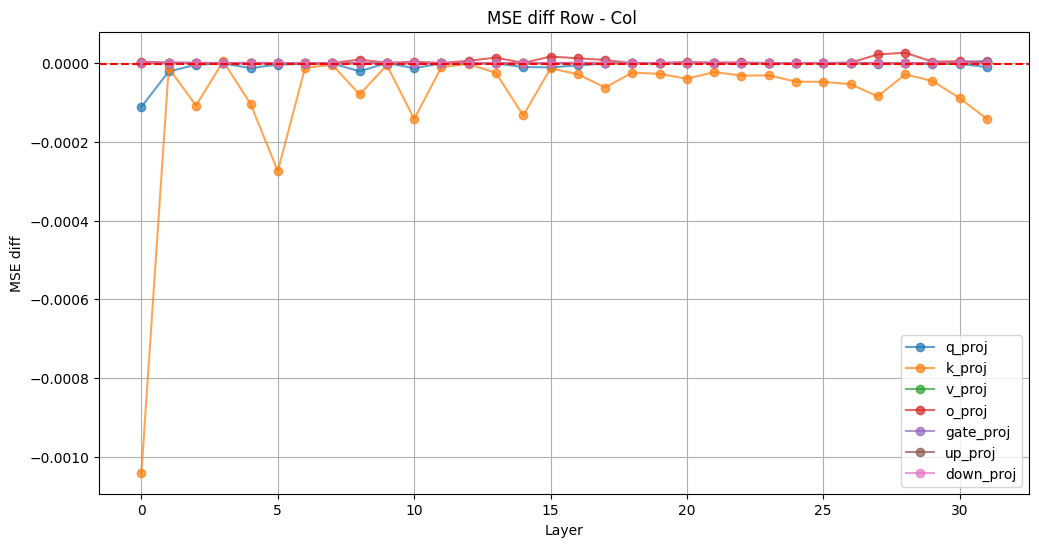

In [116]:
fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(111)

for k, v in diff.items():
    v = np.array(v) / std**2
    # v = (v - v.min()) / (v.max() - v.min())
    ax0.plot(np.arange(len(v)), v, alpha = 0.7, label=k, marker='o')
ax0.legend()
ax0.grid()
ax0.set_xlabel('Layer')
ax0.set_ylabel('MSE diff')
ax0.set_title('MSE diff Row - Col ')
ax0.axhline(y=total_diff, color='r', linestyle='--', label='total_diff')


In [117]:
total_diff

tensor(-1.6517e-06)

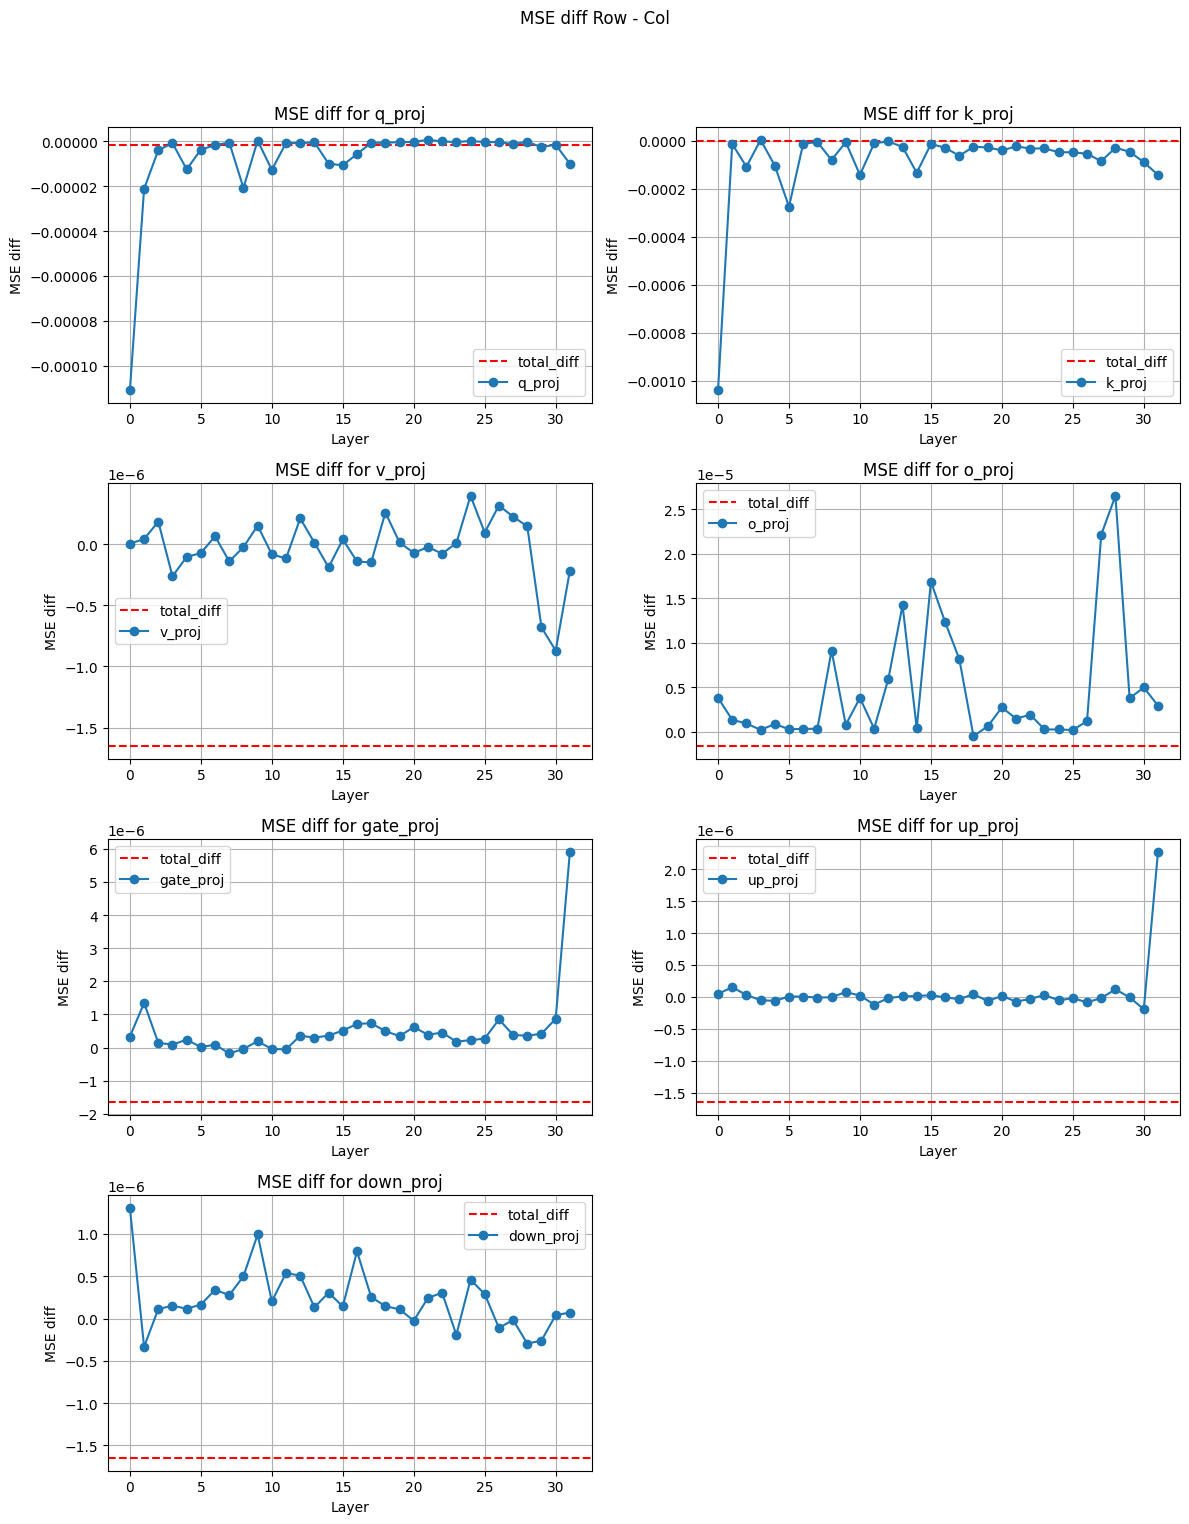

In [118]:
num_plots = len(diff)
cols = 2  # 열 수 설정
rows = (num_plots + cols - 1) // cols  # 필요한 행 수 계산

fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows))  # 전체 그림 크기와 서브플롯 배열
fig.suptitle('MSE diff Row - Col')

axs = axs.ravel()  # 2D array를 1D array로 변환

for i, (k, v) in enumerate(diff.items()):
    v = np.array(v) / std**2
    axs[i].axhline(y=total_diff, color='r', linestyle='--', label='total_diff')
    axs[i].plot(np.arange(len(v)), v, alpha=1, label=k, marker='o')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_xlabel('Layer')
    axs[i].set_ylabel('MSE diff')
    axs[i].set_title(f'MSE diff for {k}')
    

# 불필요한 서브플롯 비활성화
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 전체 레이아웃 조정
plt.show()